In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import ee
import folium
import rasterio
import geemap as emap
import geemap.eefolium as geemap
from ipyleaflet import Map, basemaps, basemap_to_tiles
from rasterio import plot
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif,RFECV,RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc

# Desafío Agtech 2020

## Objetivo
Construir un método de aprendizaje supervisado que mediante imágenes satelitales y la verdad de campo de cosechas previas pueda clasificar cultivos para distintos puntos geográficos del departamento de General López, Santa Fé.

## Dataset
Contiene las siguientes columnas:

**Id**: Integer - Es el identificador del dataset particular para la salida a campo.

**Cultivo**: Character - Es el tipo de cultivo que se encuentra en el punto. Target.

**Longitud**: Numeric - Coordenada angular.

**Latitud**: Numeric - Coordenada angular.

**Elevacion**: Numeric - Elevación del terreno.

**Dataset**: Character - Proovedor de la verdad de campo. BC: Bolsa de Cereales de Buenos Aires; BCR: Bolsa de Comercio de Rosario.

**Campania**: Character - Campaña de la cual ha sido obtenida la verdad de campo. Existen dos campañas: 18/19 y 19/20.

**GlobalId**: Integer - Es el identificador global del dataset.

In [2]:
data = pd.read_csv("../dataset/data_train.csv")

In [3]:
data.head()

,Id,Cultivo,Longitud,Latitud,Elevacion,Dataset,Campania,GlobalId
0,1,S,-62.144163,-33.800202,104.111862,BC,18/19,1
1,4,M,-62.155418,-33.801742,105.698082,BC,18/19,4
2,6,N,-62.163615,-33.808092,104.233162,BC,18/19,6
3,7,M,-62.164773,-33.813671,103.859932,BC,18/19,7
4,9,M,-62.097200,-33.778628,98.532104,BC,18/19,9


In [4]:
data.shape

(850, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         850 non-null    int64  
 1   Cultivo    850 non-null    object 
 2   Longitud   850 non-null    float64
 3   Latitud    850 non-null    float64
 4   Elevacion  850 non-null    float64
 5   Dataset    850 non-null    object 
 6   Campania   850 non-null    object 
 7   GlobalId   850 non-null    int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 53.2+ KB


## Tipos de cultivos
Graficamos por tipo de cultivo y observamos que el **75%** corresponde a:

Soja 1 = 40%

Soja 2 = 10%

Maiz temprano = 25%

El **20%** está compuesto por forrajes, pasturas verdes, campo natura y otros sin clasificar.

Y esto resto **5%** por otros cultivos menores.

In [6]:
pd.pivot_table(data, values = "Id", index = "Cultivo", aggfunc = "count")

,Id
Cultivo,
A,2
B,6
G,1
M,210
N,82
P,55
R,6
S,344
S/M,1


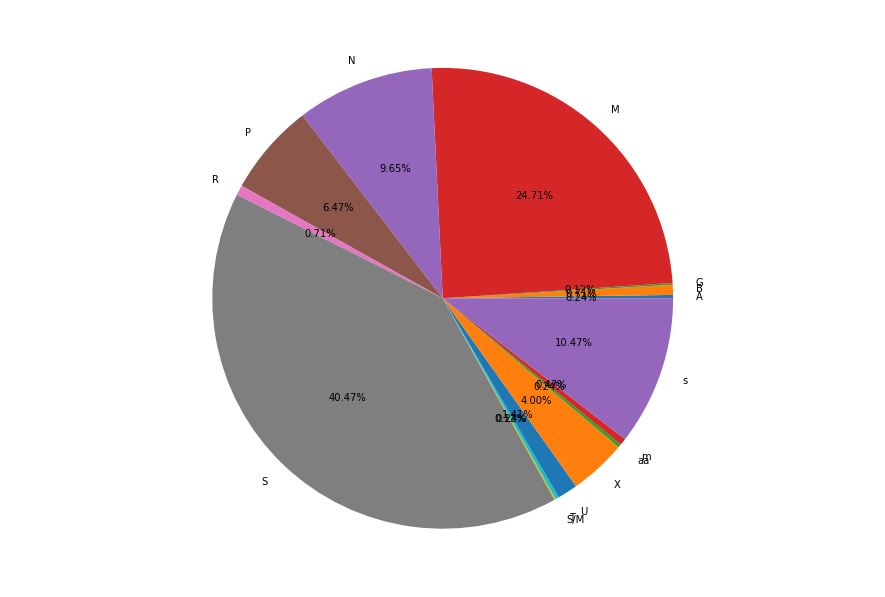

In [7]:
fig = plt.figure()
ax = fig.add_axes([1,1,2,2])
ax.axis('equal')
cultivo = ['A', 'B', 'G', 'M', 'N', 'P', 'R', 'S', 'S/M', 'T', 'U', 'X', 'aa', 'm', 's']
cantidad = [2, 6, 1, 210, 82, 55, 6, 344, 1, 2, 12, 34, 2, 4, 89]
ax.pie(cantidad, labels = cultivo,autopct='%1.2f%%')
plt.show()

## Graficamos la ubicación de los puntos muestrales

In [8]:
map_data = gpd.read_file("../dataset/data_train.csv")
gdf = gpd.GeoDataFrame(map_data, geometry=gpd.points_from_xy(map_data.Longitud, map_data.Latitud))

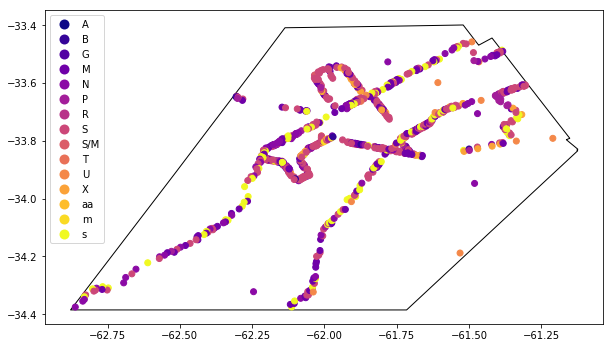

In [9]:
base = gpd.read_file("../dataset/departamento.json")
mask = base["fna"] == 'Departamento General López'
general_lopez_ok = base.loc[mask]

ax = general_lopez_ok.plot(color='white', edgecolor='k', figsize = (10, 10))

gdf.plot(column = "Cultivo", ax=ax, cmap="plasma", legend = "Cultivo")

plt.show()

## Visualizamos la ubicación delos campos a clasificar

In [10]:
map_data_test = gpd.read_file("../dataset/data_test.csv")
gdf_test = gpd.GeoDataFrame(map_data_test, geometry=gpd.points_from_xy(map_data_test.Longitud, map_data_test.Latitud))

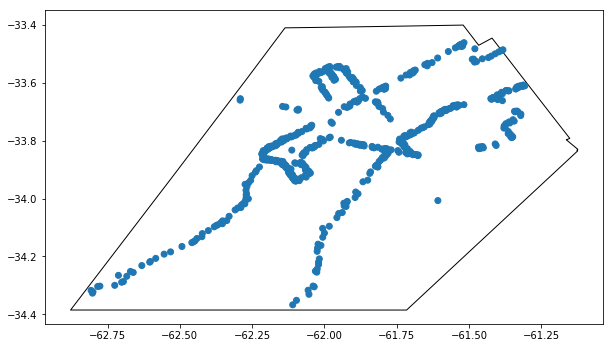

In [11]:
ax = general_lopez_ok.plot(color='white', edgecolor='k', figsize = (10, 10))

gdf_test.plot(column = "Cultivo", ax=ax )

plt.show()

## Buscamos las imágenes satelitales
Para ello utilizaremos el satelite Sentinel 2 ya que es el que mejor resolución ofrece.

Sentil 2 = COPERNICUS/S2

Tomaremos las imágenes en las fechas en las que los cultivos principales alcanza su estado de madurez:

**Maíz temprano = Diciembre**

**Soja 1 = Enero**

Coordenadas MGRS = 20HPH12014691

## Visualizamos las imagenes encontradas y elegimos las que incluyan la mayor cantidad de puntos

#### **Diciembre**

In [14]:
#plt.imshow(rgb_dic)

In [16]:
#!pip install geemap

In [156]:
ee.Authenticate()

Enter verification code:  4/1AY0e-g43hbPqH7VOgugUzneHPt-fqfieVheDcQiuck7FHzWQCxTt-XSRaXY



Successfully saved authorization token.


In [157]:
ee.Initialize()

In [158]:
general_lopez = ee.FeatureCollection('users/MLanabere/departamento')

In [159]:
bandas = ('B8A','B4','B11', 'B2', 'B3', 'B5','B6','B7','B8')

In [160]:
imagenes_sentinel = ee.ImageCollection('COPERNICUS/S2')\
                      .filterBounds(general_lopez)\
                      .filterDate('2019-12-01', '2020-01-30')\
                      .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than', 8)\
                      .mean()

In [161]:
escala_viz = {'bands': ['B4', 'B3', 'B2'],'min': 0, 'max': 10000}

In [119]:
Map = geemap.Map()

In [142]:
Map.setCenter(-61.96, -33.64, 8)
Map.addLayer(imagenes_sentinel, vis_params = escala_viz, name = 'sentinel')
Map

In [169]:
coleccion_sen2 = ee.ImageCollection('COPERNICUS/S2')\
  .filterDate('2019-12-01','2020-03-30')\
  .filterBounds(ee.Geometry.Point(-33.78, -62.15))

In [170]:
scene = coleccion_sen2.first()
scene

In [171]:
Map.centerObject((-33.78, -62.15), 9)
Map.addLayer(scene, vis_params = escala_viz, name = 'default RGB')
visParams = {bands: ['B4', 'B3', 'B2'], max: 0.3};
Map.addLayer(scene, visParams, 'true-color composite')
Map

EEException: Image.visualize: Parameter 'image' is required.